In [1]:
import numpy as np

unstable_trials = [19,18,30,26,29,25,17,23,20,28,3,22,24,21,4,31,16,11,7,2,5,15,9,8,1,10,12,27,13,14,6,0][:14]
stable_trials = [val for val in range(32) if not val in unstable_trials]

tmp1 = np.load("pacs_interactions_average.numpy", allow_pickle=True)
pacs_com_dists_hist = np.load("pacs_com_dists_hist.numpy", allow_pickle=True)
pacs_interactions_average_stable = np.sum(tmp1[stable_trials], axis=0)*150/np.sum(pacs_com_dists_hist[stable_trials,:150])
pacs_interactions_average_unstable = np.sum(tmp1[unstable_trials], axis=0)*150/np.sum(pacs_com_dists_hist[unstable_trials,:150])

In [2]:
import mdtraj as md

gleap_target = md.load("../2_md-preparation/gleap.target.gro")
target_indices = gleap_target.topology.select("resid 0 to 48")
protein_indices = gleap_target.topology.select("resid 5 to 48")
protein_min_index = min(protein_indices)

1 G2-H21=D425-OD2 0.9524843152808826 0.9552643638300242 -0.0027800485491416005
1 G2-H1=D425-OD1 0.9334679454820798 0.9482790651589649 -0.014811119676885087
1 G2-H1=D425-OD2 0.8592413643902793 0.8008075203428245 0.058433844047454775
1 G2-H21=D425-OD1 0.524049902646571 0.679295525197855 -0.15524562255128393
1 G2-H22=Q420-O 0.3665897454388116 0.000854584411884916 0.3657351610269267
1 G2-N7=W440-HE1 0.2412598254849643 0.38739921477316364 -0.14613938928819933
2 G3-O6=F438-H 0.9250883392226147 0.9622992036264104 -0.03721086440379573
2 G3-N7=R441-HH21 0.9192471334823683 0.9548556495460795 -0.03560851606371118
2 G3-O6=R441-HE 0.8861181221605251 0.9409345933292875 -0.054816471168762426
2 G3-H1=M436-O 0.7833381409100743 0.9182819137736714 -0.13494377286359716
2 G3-H21=M436-O 0.6975625585923414 0.8532220309384327 -0.15565947234609134
2 G3-N7=R441-HE 0.49475373188144506 0.3969854225238726 0.09776830935757247
3 U4-O4=N445-HD22 0.6322131679526934 0.39084232298336663 0.24137084496932681
3 U4-O4=N435-

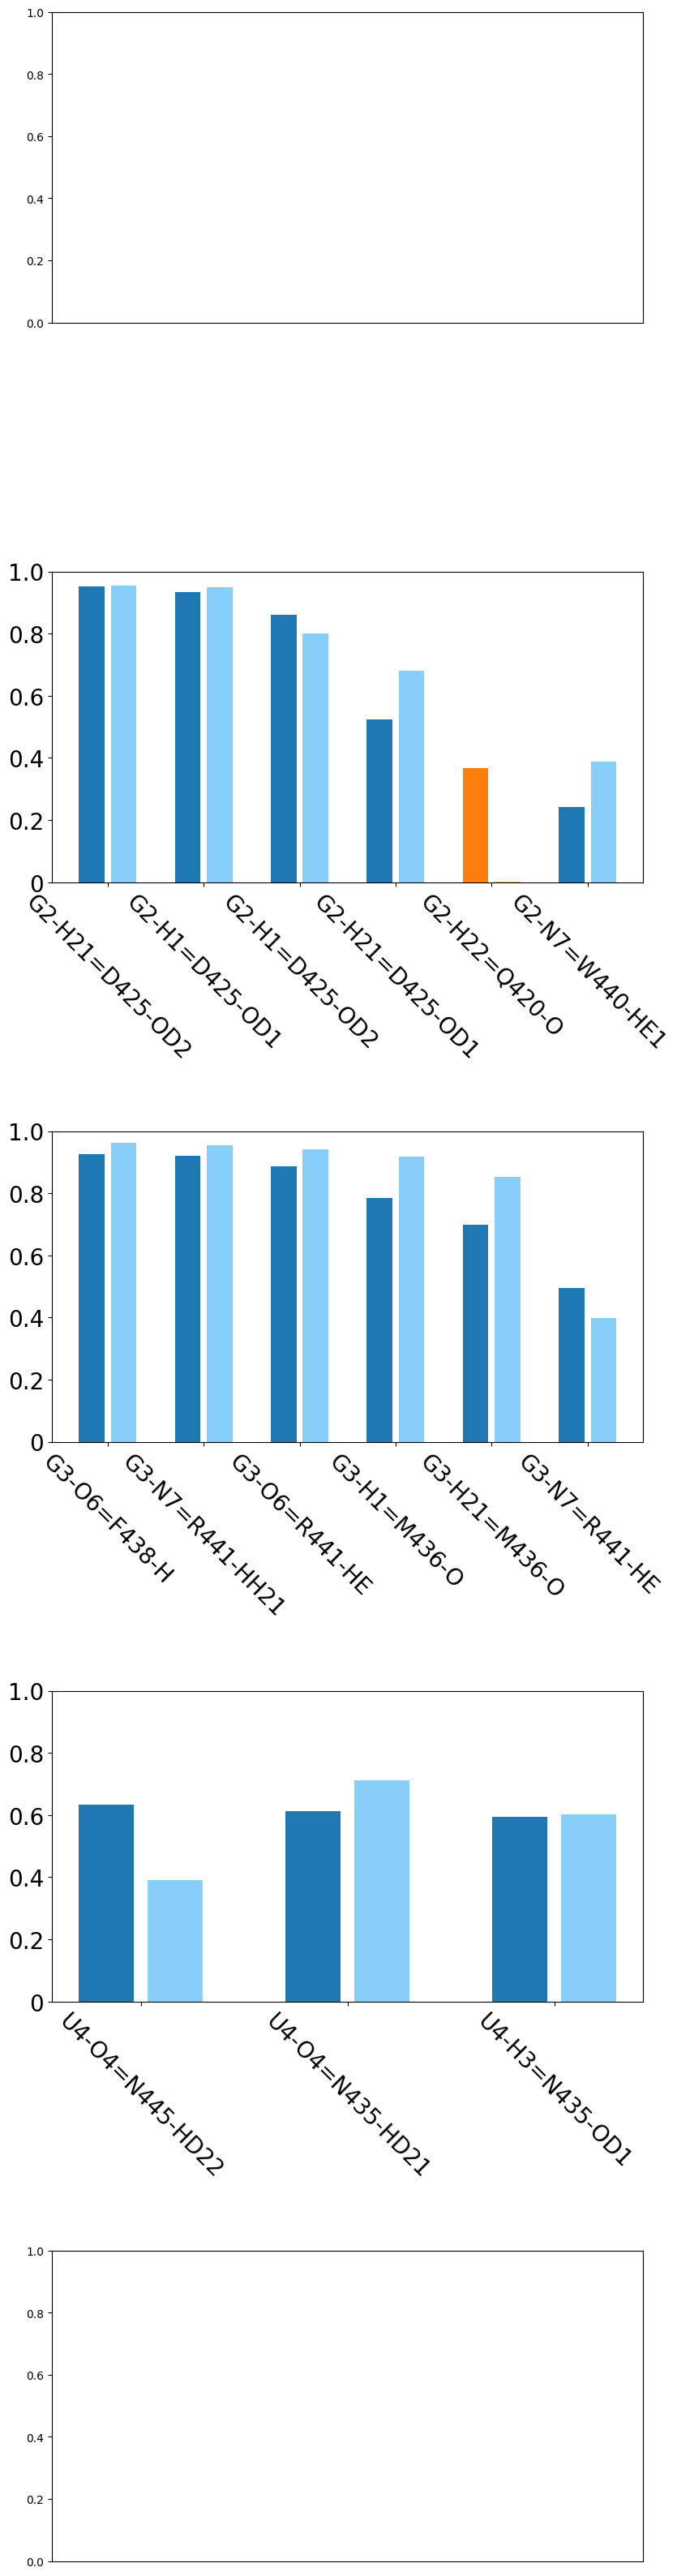

In [3]:
import matplotlib.pyplot as plt

dominant_hbonds = [[] for _ in range(5)]

for rna_res_idx in range(0, 5):
    for rna_atom_idx in gleap_target.topology.select(f"resid {rna_res_idx}"):
        for protein_res_idx in range(5, 49):
            for protein_atom_idx in gleap_target.topology.select(f"resid {protein_res_idx}"):
                stable = pacs_interactions_average_stable[protein_atom_idx-protein_min_index][rna_atom_idx]
                unstable = pacs_interactions_average_unstable[protein_atom_idx-protein_min_index][rna_atom_idx]
                if stable > 0.3 or unstable > 0.3:
                    dominant_hbonds[rna_res_idx].append((rna_atom_idx, protein_atom_idx, stable, unstable))
    dominant_hbonds[rna_res_idx].sort(key=lambda x: x[2], reverse=True)

fig, ax = plt.subplots(5, 1)
fig.set_size_inches(8, 32)
fig.tight_layout(pad=1, w_pad=1, h_pad=20)

def get_label(rna_atom, protein_atom):
    rna_label = f"{rna_atom.residue.name}{rna_atom.residue.index+1}-{rna_atom.name}"
    protein_name = protein_atom.residue.name[0]+protein_atom.residue.name[1:].lower()
    protein_label = f"{protein_atom.residue.code}{protein_atom.residue.index+408}-{protein_atom.name}"
    return f"{rna_label}={protein_label}"

for rna_res_idx in range(0, 5):
    offset = 0
    ticks = []
    for rna_atom_idx, protein_atom_idx, stable, unstable in dominant_hbonds[rna_res_idx]:
        stable_color = ""
        unstable_color = ""
        if protein_atom_idx < min(gleap_target.topology.select(f"resid 15 ot 48")):
            stable_color = "tab:orange"
            unstable_color = "#FFBE67"
        else:
            stable_color = "tab:blue"
            unstable_color = "lightskyblue"
        ax[rna_res_idx].bar(offset, stable, color=stable_color)
        ax[rna_res_idx].bar(offset+1, unstable, color=unstable_color)
        ax[rna_res_idx].set_ylim(0, 1.1)
        label = get_label(gleap_target.topology.atom(rna_atom_idx), gleap_target.topology.atom(protein_atom_idx))
        ax[rna_res_idx].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], [0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=20)
        ax[rna_res_idx].set_ylim(0, 1)
        ticks.append(label)
        print(rna_res_idx, label, stable, unstable, stable-unstable)
        offset+=3
    ax[rna_res_idx].set_xticks(np.array(range(len(dominant_hbonds[rna_res_idx])))*3+0.5, ticks, rotation=-45, fontsize=20)